# The handshake in subgroups scheduler

Making a schedule/roster for people meeting each other in subgroups with the goal for each person to meet another exactly once over the different meeting rounds.

In [12]:
class Person():
    def __init__(self, id, name, nr_persons, all_persons_names):
        if id < nr_persons: self.id = id  
        else: raise ValueError('Wrong value for id')
        self.name = name
        self.met_counter = {name:0 for name in all_persons_names}
    
    def __str__(self):
        return self.name
        
class Room():
    def __init__(self, name, size):
        self.name = name
        self.persons = []
        self.size = size
        self.checked_persons = [[] for i in range(size)]  # nested list, per position
    
    def add_person(self, person, max_meets_allowed):
        """Tries to add person to a room and returns if adding person was succesfull."""
        if len(self.persons) >= self.size: raise ValueError('[ValueError] The room is already full.')
        # check if the person is not already in the room
        if person in self.persons:
            raise ValueError('[ValueError] Person was already in the room.')
            return False
        
        # add the person to the checked persons list fpr the current position
        self.checked_persons[len(self.persons)].append(person)
        # check if the max number of meets between persons is not violated
        for p in self.persons:
            if p.met_counter[person.name] >= max_meets_allowed:
                return False
        # No check error so add person
        for p in self.persons:
            p.met_counter[person.name] += 1
            person.met_counter[p.name] += 1
        self.persons.append(person)
        return True
        
    def remove_last_person(self):
        """Remove the last added person and the tried persons since that person"""
        if len(self.persons) == 0:
            raise ValueError("[ValueError] Can't remove a person: no more persons left to remove.")
        person = self.persons[-1]
        self.persons.pop()
        for p in self.persons:
            p.met_counter[person.name] -= 1
            person.met_counter[p.name] -= 1 
        
        # Reset the checked persons lists for the position where it went wrong
        self.checked_persons[len(self.persons)] = []
              
    def __str__(self):
        nl = '\n * '
        return f"\n ### Room { self.name } \n has { len(self.persons) } persons: \n * { nl.join(p.__str__() for p in self.persons) } \n"

class Round():
    def __init__(self, round_number, persons):
        self.round_number = round_number
        self.persons_this_round = [p for p in persons]
        self.scheduled_persons = []
        self.rooms = []
    
    def __str__(self):
        nl = '\n '
        return f"\n # Round { self.round_number } \n has { len(self.rooms) } rooms: \n { nl.join([room.__str__() for room in self.rooms]) } \n "
    
                     

In [21]:
class Schedule():
    def __init__(self, max_meets_allowed, nr_rounds, nr_rooms, nr_persons_per_room, person_names=None, room_names=None):
        """Initialize the schedule object."""
        # Persons
        self.person_names = [str(i) for i in range(16)] if not person_names else person_names
        self.nr_persons = len(self.person_names)
        self.persons = [Person(i, self.person_names[i], nr_persons = self.nr_persons, all_persons_names = self.person_names) 
                        for i in range(self.nr_persons)]

        # Max-meets
        self.max_meets_allowed = max_meets_allowed

        # Rounds
        self.nr_rounds = nr_rounds
        self.rounds = [Round(i+1, self.persons) for i in range(self.nr_rounds)]

        # Fill rounds with rooms
        self.nr_rooms = nr_rooms 
        self.nr_persons_per_room = nr_persons_per_room
        if sum(self.nr_persons_per_room[:self.nr_rooms]) != self.nr_persons: raise ValueError('[ValueError] Number of persons per room does not match with the total number of persons')
        self.room_names = [c for c in "ABCDEFGHIJ"] if not room_names else room_names
        for rnd in self.rounds:
            rnd.rooms = [Room(self.room_names[i], self.nr_persons_per_room[i]) for i in range(self.nr_rooms)]
        # TODO: Refactoring for later, nr_rooms can be determined from nr_persons_per_room, no seperate input needed.
        # TODO: Nicer to combine room_names and nr_persons_per_room in list of tuples.
        
    
    
    def make_schedule(self, verbose=False):
        """Try to make a schedule."""
        
        def loop_over_available_persons_and_try(max_meets_allowed):
            """Loop over available persons with an other max_meets_allowed each time."""
            # for each available person
            for p in rnd.persons_this_round:
                if p in rnd.scheduled_persons:
                    continue # the person was already scheduled
                if verbose: print(f"Now looking at person {p.name} for room {room.name} during round {rnd.round_number}.")
                # Try to add person
                if room.add_person(p, max_meets_allowed):
                    rnd.scheduled_persons.append(p)
                    if verbose: print(f"  Person {p.name} is added to room {room.name} for round {rnd.round_number}.")
                    #print(f"lenth of persons: {len(persons)}")

                # if person ading was successfull the room could be full
                # break out of unscheduled person loop early if so
                if len(room.persons) >= room.size:
                    return True #room_is_full = True
            return False
        
        # for each round
        for rnd in self.rounds:
            # for each room
            for room in rnd.rooms:
                room_is_full = loop_over_available_persons_and_try(max_meets_allowed = 1)

                

                if not room_is_full:
                    # no more persons available for this round/room
                    # however the room is not full, thus go back
    
                    # Experimental, not working, not optimized at all!!:
                    max_meets_allowed = self.max_meets_allowed
                    while not room_is_full:
                        max_meets_allowed += 1
                        print(f'Warning, was not able to make a schedule where you do not meet people twice. \n Increasing max_meets_allowed to {max_meets_allowed}.')
                        room_is_full = loop_over_available_persons_and_try(max_meets_allowed)
                    # TODO Implement this
                    # Unfortunately here I had already a working schedule, 
                    # with the configuration 16 persons with 5 rounds with 4 rooms of 4 people.
                    # (Each round the person meets 3 others. After 5 rounds thus 15 different people 
                    # are reached. In this case, with this implementation it is possible to solve
                    # for all 16 people to meet all 15 others in 5 rounds.)
                    # So not necessary to implement,
                    # But otherwise cancel last step in the order:
                        # if people in room:
                            # apply the remove_person function on the room
                        # else if still previous room in round
                            # navigate to room and apply the remove_person function on the room
                        # else if still previous rounds in schedule
                            # navigat to last room in the previous round and apply the remove_peron function on the room
                        # else:
                            # all the options were tried, no solution is possible, try to soften the parameters:
                                # retry with an higher max_allowed meets or
                                # try another configuration of number of rooms and/or number of rounds 
                                # and/or number of people.
                    # Also it would be nice when the max_allowed_meets is higher, that the number of occasions
                    # this is used is still minimized.
                    # TODO research building larger rooms iteratively by merging smaller ones, i.e. best 
                    # solution for 2 rooms of 8 is making a solution for 4 rooms of 4 and then combining rooms in a larger oner.
    

    def make_markdown_table(self, body, col_headers=None, row_headers=None):
        """Convert a nested list to a pretty outlined markdown table."""   
        column_width = max(len(cell) if isinstance(cell,str) else len('<br>'.join(cell)) for row in body + ([col_headers] if col_headers else []) for cell in row) + 1 # For prettifying/outlining the content in the markdown table
        column_width = max(column_width, 5) # The column width should be at least 5 for the header row to work
        
        if col_headers: # Begin with two header rows.
            table = [f"|{ '|'.join([' ' * (column_width-len(h)) + h for h in col_headers]) }|"]
            table += [f"{ ''.join('|:' + '-' * (column_width-2) + ':' for i in range(len(body[0]))) }| "]

        # body
        for row in body:
            try: # If the cell contains a list, make the cell a newline seperated string.           
                table += [f"| {'| '.join(' ' * (column_width-1-len('<br>'.join(cell))) + '<br>'.join(cell) for cell in row) }|"]
            except: # Cell does not contain a list.
                table += [f"| {'| '.join([' ' * (column_width-len(cell)-1) + cell for cell in row]) }|"]

        if row_headers: # Insert a column before.
            # Depends on the presence of col-headers, the row-headers values should start after the row headers.
            start_row = 0
            column_width = max(max(len(h) for h in row_headers) + 6,5) # 6 for compensating leading space and ** and trailing ** and space, excluding leading | 
            if col_headers:
                table[0] = f"|{' ' * (column_width)}" + table[0]
                table[1] = f"|:{'-' * (column_width-2)}:" + table[1]
                start_row = 2
            for i,row in enumerate(table):
                if i >= start_row:
                    h = row_headers[i-start_row]
                    leading_spaces = ' ' * (column_width-(len(h)+6))
                    table[i] = f"|{ leading_spaces } **{ h }** " + table[i]

        nl = '\n' # f-strings do not allow a backslash, but do allow a string variable with inside a backslash
        return nl.join(table)

    def make_roadmap_per_person_matrix(self):
        """Returns a nested list with per row a person, in the columns the rounds and in the cell, 
        where that person should be during that round."""
        mat = [[[room.name for room in rnd.rooms if p in room.persons ] for rnd in self.rounds]for p in self.persons]                
        return mat

    def make_md_roadmap_per_person_table(self):
        """Converts the roadmap per person to a table with MD styling."""
        return self.make_markdown_table(
            self.make_roadmap_per_person_matrix(), 
            [f"round {rnd.round_number}" for rnd in self.rounds], 
            [p.name for p in self.persons]
         )

    def make_person_meet_person_matrix(self):
        """Returns a nested list with in the rows and columns the people and in 
        the cells where they meet."""                  
        #for rnd in rounds:
        #    for room in rnd.rooms:
        #        for i,p1 in enumerate(room.persons):
        #            for p2 in room.persons[:i]:
        #                if p1.id != p2.id:
        #                    table[p1.id][p2.id] += [f"{rnd.round_number} - {room.name}"]
        #                    table[p2.id][p1.id] += [f"{rnd.round_number} - {room.name}"]
        return [
            [
                [
                    f"{rnd.round_number} - {room.name}"
                    for rnd in self.rounds 
                    for room in rnd.rooms 
                    if p1 in room.persons and p2 in room.persons and p1 != p2] 
                for c, p2 in enumerate(self.persons)] 
            for r, p1 in enumerate(self.persons)]

    def make_md_person_meet_person_table(self):
        """Converts the person-meet-person matrix to a table with MD styling."""
        return self.make_markdown_table(
            self.make_person_meet_person_matrix(), 
            [p.name for p in self.persons], 
            [p.name for p in self.persons]
        )

    def make_schedule_matrix(self):
        """Returns a nested list with as rows the rooms, as columns the rows and as cells the people
        present in that room during that round"""
        mat = [[[p.name for p in room.persons] for room in rnd.rooms] for rnd in self.rounds]
        mat = [list(x) for x in zip(*mat)] #transpose: in order that rows are the rooms and columns the rounds                 
        return mat

    def make_md_schedule_table(self):
        """Converts the schedule to a table styled with MD."""
        return self.make_markdown_table(
            self.make_schedule_matrix(), 
            [f'round {rnd.round_number}' for rnd in self.rounds], 
            [f"room<br>{ room.name}" for room in self.rounds[0].rooms]
        )
    
    def create_p2p_stats(self):
        """Create a grouped bar chart per person."""
        # libraries
        import numpy as np
        import matplotlib.pyplot as plt
        import functools
        
        #Get data
        p2p_data = self.make_person_meet_person_matrix()
                        
        # set width of bar
        barWidth = 0.2

        # set height of bar
        bars1 = [sum(1 if len(p2p) == 0 else 0 for p2p in p) - 1 for p in p2p_data] # 0 handshake, -1 for correcting not meeting yourself
        bars2 = [sum(1 if len(p2p) == 1 else 0 for p2p in p) for p in p2p_data] # 1 handshake
        bars3 = [sum(1 if len(p2p) == 2 else 0 for p2p in p) for p in p2p_data] # 2 handshakes
        bars4 = [sum(1 if len(p2p) > 2 else 0 for p2p in p) for p in p2p_data] # 3 or more handshakes                

        # Set position of bar on X axis
        r1 = np.arange(len(bars1))
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        
        # Make the plot
        plt.figure(figsize=(15,4))
        plt.bar(r1, bars1, color='#28a745', width=barWidth, edgecolor='white', label='0 meets')
        plt.bar(r2, bars2, color='#6c757d', width=barWidth, edgecolor='white', label='1 meet')
        plt.bar(r3, bars3, color='#ffc107', width=barWidth, edgecolor='white', label='2 meets')
        plt.bar(r4, bars4, color='#dc3545', width=barWidth, edgecolor='white', label='>2 meets')

        # Add xticks on the middle of the group bars
        plt.title('Meet stats per person', fontweight='bold')
        plt.xticks([r + barWidth for r in range(len(bars1))], self.person_names)
        
        # Set the lines                  
        plt.box(on=None)
        plt.grid(which = 'major', axis = 'y', linewidth = 0.2)

        # Create legend & Show graphic
        plt.legend()
        plt.show()         
        
        most_doubles = functools.reduce(
                lambda a,b : a if a[0]+a[1] > b[0]+b[1] else (a[0],a[1],a[2]+', '+b[2]) if a[0]+a[1] == b[0]+b[1] else b, 
                zip(bars3,bars4,self.person_names))
        fewest_doubles = functools.reduce(
                lambda a,b : a if a[0]+a[1] < b[0]+b[1] else (a[0],a[1],a[2]+', '+b[2]) if a[0]+a[1] == b[0]+b[1] else b, 
                zip(bars3,bars4,self.person_names))
        most_0 = functools.reduce(
                lambda a,b : a if a[0] > b[0] else (a[0],a[1]+', '+b[1]) if a[0] == b[0] else b, 
                zip(bars1,self.person_names))
        fewest_0 = functools.reduce(
                lambda a,b : a if a[0] < b[0] else (a[0],a[1]+', '+b[1]) if a[0] == b[0] else b, 
                zip(bars1,self.person_names))
        return {'Number of people that dont meet': sum(1 if b != 0 else 0 for b in bars1), 
            'Average number of persons that succesfully meet':sum(a + b + c + d for (a,b,c,d) in zip(bars1,bars2,bars3,bars4))/len(self.person_names),
            ' ':' ',
            'Person with the most doubles':f"{most_doubles[2]} [{most_doubles[0]+most_doubles[1]}]",
            'Person with the fewest doubles':f"{fewest_doubles[2]} [{fewest_doubles[0]+fewest_doubles[1]}]",
            '  ':'  ',
            'Person with the most 0 meets':f"{most_0[1]} [{most_0[0]}]",
            'Person with the fewest 0 meets':f"{fewest_0[1]} [{fewest_0[0]}]"
               }
    
    def print_schedule_stats(self):
        """Print some matching stats."""
        print('\n\n')
        stats = self.create_p2p_stats()
        print("\nMatching stats\n")
        for key,val in stats.items():
            print(f"{key + ' :':<50} {val}")
                          
    def print_schedules_in_jupyter_notebook(self, schedule = True, roadmap = True, person_meets_person = True):
        """Prints the schedules styled by markdown directly in jupyter notebook."""

        from IPython.display import Markdown, display
        def printmd(string):
            """Print md styled text in jupyter notebook."""
            display(Markdown(string))
        
        print("\n\nThe overall schedule")
        printmd(self.make_md_schedule_table())
        
        print("\n\nThe matrix where each person meets each other in round number - room")
        printmd(self.make_md_person_meet_person_table())
        
        print("\n\nThe roadmap per person")
        printmd(self.make_md_roadmap_per_person_table())
    
    def print_schedules(self, schedule = True, roadmap = True, person_meets_person = True):
        """Prints the schedules styled by markdown as strings"""
                          
        print("The output in pure markdown.")                
                          
        print("\n\nThe overall schedule\n")
        print(self.make_md_schedule_table())
        
        print("\n\nThe matrix where each person meets each other in round number - room\n")
        print(self.make_md_person_meet_person_table())
        
        print("\n\nThe roadmap per person\n")
        print(self.make_md_roadmap_per_person_table())

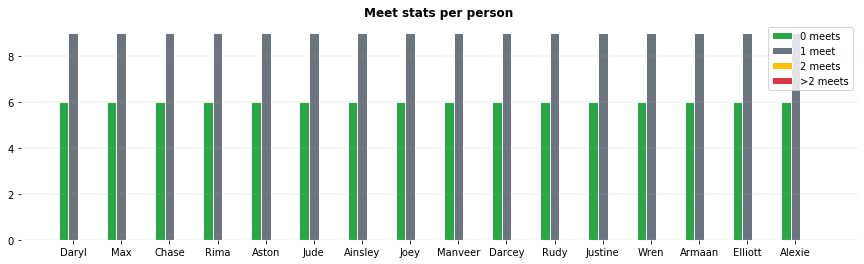


Matching stats

Number of people that dont meet :                  16
Average number of persons that succesfully meet :  15.0
  :                                                 
Person with the most doubles :                     Daryl, Max, Chase, Rima, Aston, Jude, Ainsley, Joey, Manveer, Darcey, Rudy, Justine, Wren, Armaan, Elliott, Alexie [0]
Person with the fewest doubles :                   Daryl, Max, Chase, Rima, Aston, Jude, Ainsley, Joey, Manveer, Darcey, Rudy, Justine, Wren, Armaan, Elliott, Alexie [0]
   :                                                 
Person with the most 0 meets :                     Daryl, Max, Chase, Rima, Aston, Jude, Ainsley, Joey, Manveer, Darcey, Rudy, Justine, Wren, Armaan, Elliott, Alexie [6]
Person with the fewest 0 meets :                   Daryl, Max, Chase, Rima, Aston, Jude, Ainsley, Joey, Manveer, Darcey, Rudy, Justine, Wren, Armaan, Elliott, Alexie [6]


The overall schedule


|               |                              round 1|                              round 2|                              round 3|
|:-------------:|:-----------------------------------:|:-----------------------------------:|:-----------------------------------:| 
| **room<br>A** |        Daryl<br>Max<br>Chase<br>Rima|    Daryl<br>Aston<br>Manveer<br>Wren|      Daryl<br>Jude<br>Rudy<br>Alexie|
| **room<br>B** |     Aston<br>Jude<br>Ainsley<br>Joey|      Max<br>Jude<br>Darcey<br>Armaan|   Max<br>Aston<br>Justine<br>Elliott|
| **room<br>C** | Manveer<br>Darcey<br>Rudy<br>Justine|  Chase<br>Ainsley<br>Rudy<br>Elliott|   Chase<br>Joey<br>Manveer<br>Armaan|
| **room<br>D** |  Wren<br>Armaan<br>Elliott<br>Alexie|    Rima<br>Joey<br>Justine<br>Alexie|    Rima<br>Ainsley<br>Darcey<br>Wren|



The matrix where each person meets each other in round number - room


|             |   Daryl|     Max|   Chase|    Rima|   Aston|    Jude| Ainsley|    Joey| Manveer|  Darcey|    Rudy| Justine|    Wren|  Armaan| Elliott|  Alexie|
|:-----------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:| 
|   **Daryl** |        |   1 - A|   1 - A|   1 - A|   2 - A|   3 - A|        |        |   2 - A|        |   3 - A|        |   2 - A|        |        |   3 - A|
|     **Max** |   1 - A|        |   1 - A|   1 - A|   3 - B|   2 - B|        |        |        |   2 - B|        |   3 - B|        |   2 - B|   3 - B|        |
|   **Chase** |   1 - A|   1 - A|        |   1 - A|        |        |   2 - C|   3 - C|   3 - C|        |   2 - C|        |        |   3 - C|   2 - C|        |
|    **Rima** |   1 - A|   1 - A|   1 - A|        |        |        |   3 - D|   2 - D|        |   3 - D|        |   2 - D|   3 - D|        |        |   2 - D|
|   **Aston** |   2 - A|   3 - B|        |        |        |   1 - B|   1 - B|   1 - B|   2 - A|        |        |   3 - B|   2 - A|        |   3 - B|        |
|    **Jude** |   3 - A|   2 - B|        |        |   1 - B|        |   1 - B|   1 - B|        |   2 - B|   3 - A|        |        |   2 - B|        |   3 - A|
| **Ainsley** |        |        |   2 - C|   3 - D|   1 - B|   1 - B|        |   1 - B|        |   3 - D|   2 - C|        |   3 - D|        |   2 - C|        |
|    **Joey** |        |        |   3 - C|   2 - D|   1 - B|   1 - B|   1 - B|        |   3 - C|        |        |   2 - D|        |   3 - C|        |   2 - D|
| **Manveer** |   2 - A|        |   3 - C|        |   2 - A|        |        |   3 - C|        |   1 - C|   1 - C|   1 - C|   2 - A|   3 - C|        |        |
|  **Darcey** |        |   2 - B|        |   3 - D|        |   2 - B|   3 - D|        |   1 - C|        |   1 - C|   1 - C|   3 - D|   2 - B|        |        |
|    **Rudy** |   3 - A|        |   2 - C|        |        |   3 - A|   2 - C|        |   1 - C|   1 - C|        |   1 - C|        |        |   2 - C|   3 - A|
| **Justine** |        |   3 - B|        |   2 - D|   3 - B|        |        |   2 - D|   1 - C|   1 - C|   1 - C|        |        |        |   3 - B|   2 - D|
|    **Wren** |   2 - A|        |        |   3 - D|   2 - A|        |   3 - D|        |   2 - A|   3 - D|        |        |        |   1 - D|   1 - D|   1 - D|
|  **Armaan** |        |   2 - B|   3 - C|        |        |   2 - B|        |   3 - C|   3 - C|   2 - B|        |        |   1 - D|        |   1 - D|   1 - D|
| **Elliott** |        |   3 - B|   2 - C|        |   3 - B|        |   2 - C|        |        |        |   2 - C|   3 - B|   1 - D|   1 - D|        |   1 - D|
|  **Alexie** |   3 - A|        |        |   2 - D|        |   3 - A|        |   2 - D|        |        |   3 - A|   2 - D|   1 - D|   1 - D|   1 - D|        |



The roadmap per person


|             | round 1| round 2| round 3|
|:-----------:|:------:|:------:|:------:| 
|   **Daryl** |       A|       A|       A|
|     **Max** |       A|       B|       B|
|   **Chase** |       A|       C|       C|
|    **Rima** |       A|       D|       D|
|   **Aston** |       B|       A|       B|
|    **Jude** |       B|       B|       A|
| **Ainsley** |       B|       C|       D|
|    **Joey** |       B|       D|       C|
| **Manveer** |       C|       A|       C|
|  **Darcey** |       C|       B|       D|
|    **Rudy** |       C|       C|       A|
| **Justine** |       C|       D|       B|
|    **Wren** |       D|       A|       D|
|  **Armaan** |       D|       B|       C|
| **Elliott** |       D|       C|       B|
|  **Alexie** |       D|       D|       A|

The output in pure markdown.


The overall schedule

|               |                              round 1|                              round 2|                              round 3|
|:-------------:|:-----------------------------------:|:-----------------------------------:|:-----------------------------------:| 
| **room<br>A** |        Daryl<br>Max<br>Chase<br>Rima|    Daryl<br>Aston<br>Manveer<br>Wren|      Daryl<br>Jude<br>Rudy<br>Alexie|
| **room<br>B** |     Aston<br>Jude<br>Ainsley<br>Joey|      Max<br>Jude<br>Darcey<br>Armaan|   Max<br>Aston<br>Justine<br>Elliott|
| **room<br>C** | Manveer<br>Darcey<br>Rudy<br>Justine|  Chase<br>Ainsley<br>Rudy<br>Elliott|   Chase<br>Joey<br>Manveer<br>Armaan|
| **room<br>D** |  Wren<br>Armaan<br>Elliott<br>Alexie|    Rima<br>Joey<br>Justine<br>Alexie|    Rima<br>Ainsley<br>Darcey<br>Wren|


The matrix where each person meets each other in round number - room

|             |   Daryl|     Max|   Chase|    Rima|   Aston|    Jude| Ainsley|    

In [22]:
# Example usage
names = ['Daryl','Max', 'Chase', 'Rima', 'Aston', 'Jude', 'Ainsley', 'Joey', 'Manveer', 'Darcey', 'Rudy', 'Justine', 'Wren', 'Armaan', 'Elliott', 'Alexie']

# Initialize the schedule object, set the configurations
new_schedule = Schedule(
    max_meets_allowed = 1, 
    nr_rounds = 3, 
    nr_rooms = 4, 
    nr_persons_per_room = [4 for i in range(4)], 
    person_names = names,
    room_names = None
)

# Make the schedule
new_schedule.make_schedule()

#print stats
new_schedule.print_schedule_stats()

# Print the schedule
try:
    new_schedule.print_schedules_in_jupyter_notebook()
except:
    print('It was not possible to print the schedules neatly, this means that..\n\n  ..or you are not running in jupiter notebook\n  ..or you do not have IPython pip installed\n\n')
    
new_schedule.print_schedules()